# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, desc
from pyspark.sql.types import IntegerType, StringType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# create a Spark session
# create a Spark session
spark = SparkSession.builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load and Clean Dataset

# Load the dataset
file_path = "mini_sparkify_event_data.json"
df = spark.read.json(file_path)

# Show the schema of the dataframe to understand its structure
df.printSchema()

# Display the first few rows of the dataframe to get an overview of the data
df.show(5)

# Clean the dataset
# Remove rows with missing userId or sessionId
df_cleaned = df.dropna(how="any", subset=["userId", "sessionId"])

# Check if there are any empty userId fields (sometimes userId can be an empty string, not null)
df_cleaned = df_cleaned.filter(df_cleaned["userId"] != "")

# Verify the cleaning steps
df_cleaned.printSchema()
df_cleaned.show(5)


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|     

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
# Import necessary functions
from pyspark.sql.functions import lit

# Define churn based on 'Cancellation Confirmation' events
churn_flag = df_cleaned.filter(df_cleaned.page == "Cancellation Confirmation") \
                       .select("userId").dropDuplicates() \
                       .withColumn("churn", lit(1))

# Join this churn information with the main dataset
df_cleaned = df_cleaned.join(churn_flag, on="userId", how="left")

# Fill NaN values in 'churn' column with 0
df_cleaned = df_cleaned.na.fill({"churn": 0})

# Verify the churn flag
df_cleaned.select("userId", "page", "churn").distinct().show(10)




+------+---------------+-----+
|userId|           page|churn|
+------+---------------+-----+
|100010|       NextSong|    0|
|100010|      Thumbs Up|    0|
|100010|    Roll Advert|    0|
|100010|           Home|    0|
|100010|         Logout|    0|
|100010|Add to Playlist|    0|
|100010|           Help|    0|
|100010|     Add Friend|    0|
|100010|    Thumbs Down|    0|
|100010|        Upgrade|    0|
+------+---------------+-----+
only showing top 10 rows



In [7]:
# Number of churned vs. non-churned users
churn_counts = df_cleaned.groupBy("churn").agg({"userId": "count"}).withColumnRenamed("count(userId)", "num_users")
churn_counts.show()

# Average number of songs played by churned vs. non-churned users
avg_songs = df_cleaned.filter(df_cleaned.page == "NextSong") \
                      .groupBy("userId", "churn") \
                      .count() \
                      .groupBy("churn") \
                      .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_songs_played")
avg_songs.show()

# Average session length for churned vs. non-churned users
avg_session_length = df_cleaned.groupBy("userId", "churn") \
                               .agg({"length": "sum"}) \
                               .groupBy("churn") \
                               .agg({"sum(length)": "avg"}).withColumnRenamed("avg(sum(length))", "avg_session_length")
avg_session_length.show()


+-----+---------+
|churn|num_users|
+-----+---------+
|    1|    44864|
|    0|   233290|
+-----+---------+

+-----+------------------+
|churn|  avg_songs_played|
+-----+------------------+
|    1| 699.8846153846154|
|    0|1108.1734104046243|
+-----+------------------+

+-----+------------------+
|churn|avg_session_length|
+-----+------------------+
|    1| 174014.2685513462|
|    0|276166.93746780336|
+-----+------------------+



In [8]:
# Average number of songs played by churned vs. non-churned users
avg_songs = df_cleaned.filter(df_cleaned.page == "NextSong") \
                      .groupBy("userId", "churn") \
                      .count() \
                      .groupBy("churn") \
                      .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_songs_played")
avg_songs.show()


+-----+------------------+
|churn|  avg_songs_played|
+-----+------------------+
|    1| 699.8846153846154|
|    0|1108.1734104046243|
+-----+------------------+



In [9]:
# Average session length for churned vs. non-churned users
avg_session_length = df_cleaned.groupBy("userId", "churn") \
                               .agg({"length": "sum"}) \
                               .groupBy("churn") \
                               .agg({"sum(length)": "avg"}).withColumnRenamed("avg(sum(length))", "avg_session_length")
avg_session_length.show()


+-----+------------------+
|churn|avg_session_length|
+-----+------------------+
|    1| 174014.2685513462|
|    0|276166.93746780336|
+-----+------------------+



In [10]:
# Average number of Thumbs Up interactions for churned vs. non-churned users
avg_thumbs_up = df_cleaned.filter(df_cleaned.page == "Thumbs Up") \
                          .groupBy("userId", "churn") \
                          .count() \
                          .groupBy("churn") \
                          .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_thumbs_up")
avg_thumbs_up.show()

# Average number of Thumbs Down interactions for churned vs. non-churned users
avg_thumbs_down = df_cleaned.filter(df_cleaned.page == "Thumbs Down") \
                            .groupBy("userId", "churn") \
                            .count() \
                            .groupBy("churn") \
                            .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_thumbs_down")
avg_thumbs_down.show()


+-----+-----------------+
|churn|    avg_thumbs_up|
+-----+-----------------+
|    1|            37.18|
|    0|62.89411764705882|
+-----+-----------------+

+-----+------------------+
|churn|   avg_thumbs_down|
+-----+------------------+
|    1|10.333333333333334|
|    0|13.225806451612904|
+-----+------------------+



In [11]:
# Average number of Thumbs Down interactions for churned vs. non-churned users
avg_thumbs_down = df_cleaned.filter(df_cleaned.page == "Thumbs Down") \
                            .groupBy("userId", "churn") \
                            .count() \
                            .groupBy("churn") \
                            .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_thumbs_down")
avg_thumbs_down.show()


+-----+------------------+
|churn|   avg_thumbs_down|
+-----+------------------+
|    1|10.333333333333334|
|    0|13.225806451612904|
+-----+------------------+



In [12]:
# Average number of Add Friend interactions for churned vs. non-churned users
avg_add_friend = df_cleaned.filter(df_cleaned.page == "Add Friend") \
                           .groupBy("userId", "churn") \
                           .count() \
                           .groupBy("churn") \
                           .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_add_friend")
avg_add_friend.show()

# Average number of Add to Playlist interactions for churned vs. non-churned users
avg_add_playlist = df_cleaned.filter(df_cleaned.page == "Add to Playlist") \
                             .groupBy("userId", "churn") \
                             .count() \
                             .groupBy("churn") \
                             .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_add_playlist")
avg_add_playlist.show()


+-----+------------------+
|churn|    avg_add_friend|
+-----+------------------+
|    1|14.454545454545455|
|    0| 22.47530864197531|
+-----+------------------+

+-----+-----------------+
|churn| avg_add_playlist|
+-----+-----------------+
|    1|            20.76|
|    0|33.26060606060606|
+-----+-----------------+



In [13]:
# Average number of Add to Playlist interactions for churned vs. non-churned users
avg_add_playlist = df_cleaned.filter(df_cleaned.page == "Add to Playlist") \
                             .groupBy("userId", "churn") \
                             .count() \
                             .groupBy("churn") \
                             .agg({"count": "avg"}).withColumnRenamed("avg(count)", "avg_add_playlist")
avg_add_playlist.show()


+-----+-----------------+
|churn| avg_add_playlist|
+-----+-----------------+
|    1|            20.76|
|    0|33.26060606060606|
+-----+-----------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [15]:
from pyspark.sql.functions import sum as Fsum, count as Fcount

# Number of songs played
num_songs = df_cleaned.filter(df_cleaned.page == "NextSong") \
                      .groupBy("userId") \
                      .agg(Fcount("page").alias("num_songs"))

# Total session length
total_session_length = df_cleaned.groupBy("userId") \
                                 .agg(Fsum("length").alias("total_session_length"))

# Number of Thumbs Up interactions
num_thumbs_up = df_cleaned.filter(df_cleaned.page == "Thumbs Up") \
                          .groupBy("userId") \
                          .agg(Fcount("page").alias("num_thumbs_up"))

# Number of Thumbs Down interactions
num_thumbs_down = df_cleaned.filter(df_cleaned.page == "Thumbs Down") \
                            .groupBy("userId") \
                            .agg(Fcount("page").alias("num_thumbs_down"))

# Number of Add Friend interactions
num_add_friend = df_cleaned.filter(df_cleaned.page == "Add Friend") \
                           .groupBy("userId") \
                           .agg(Fcount("page").alias("num_add_friend"))

# Number of Add to Playlist interactions
num_add_playlist = df_cleaned.filter(df_cleaned.page == "Add to Playlist") \
                             .groupBy("userId") \
                             .agg(Fcount("page").alias("num_add_playlist"))

# Combine all features into a single DataFrame
features = num_songs.join(total_session_length, on="userId", how="left") \
                    .join(num_thumbs_up, on="userId", how="left") \
                    .join(num_thumbs_down, on="userId", how="left") \
                    .join(num_add_friend, on="userId", how="left") \
                    .join(num_add_playlist, on="userId", how="left") \
                    .join(df_cleaned.select("userId", "churn").distinct(), on="userId", how="left")

# Fill NaN values with 0 (in case some users did not have any interaction of a certain type)
features = features.na.fill(0)

# Show the resulting feature DataFrame
features.show(5)


+------+---------+--------------------+-------------+---------------+--------------+----------------+-----+
|userId|num_songs|total_session_length|num_thumbs_up|num_thumbs_down|num_add_friend|num_add_playlist|churn|
+------+---------+--------------------+-------------+---------------+--------------+----------------+-----+
|100010|      275|   66940.89735000003|           17|              5|             4|               7|    0|
|200002|      387|   94008.87593999993|           21|              6|             4|               8|    0|
|   125|        8|  2089.1131000000005|            0|              0|             0|               0|    1|
|   124|     4079|  1012312.0927899999|          171|             41|            74|             118|    0|
|    51|     2111|   523275.8428000004|          100|             21|            28|              52|    1|
+------+---------+--------------------+-------------+---------------+--------------+----------------+-----+
only showing top 5 rows



Columns in DataFrame: Index(['userId', 'num_songs', 'total_session_length', 'num_thumbs_up',
       'num_thumbs_down', 'num_add_friend', 'num_add_playlist', 'churn'],
      dtype='object')
Missing columns: []


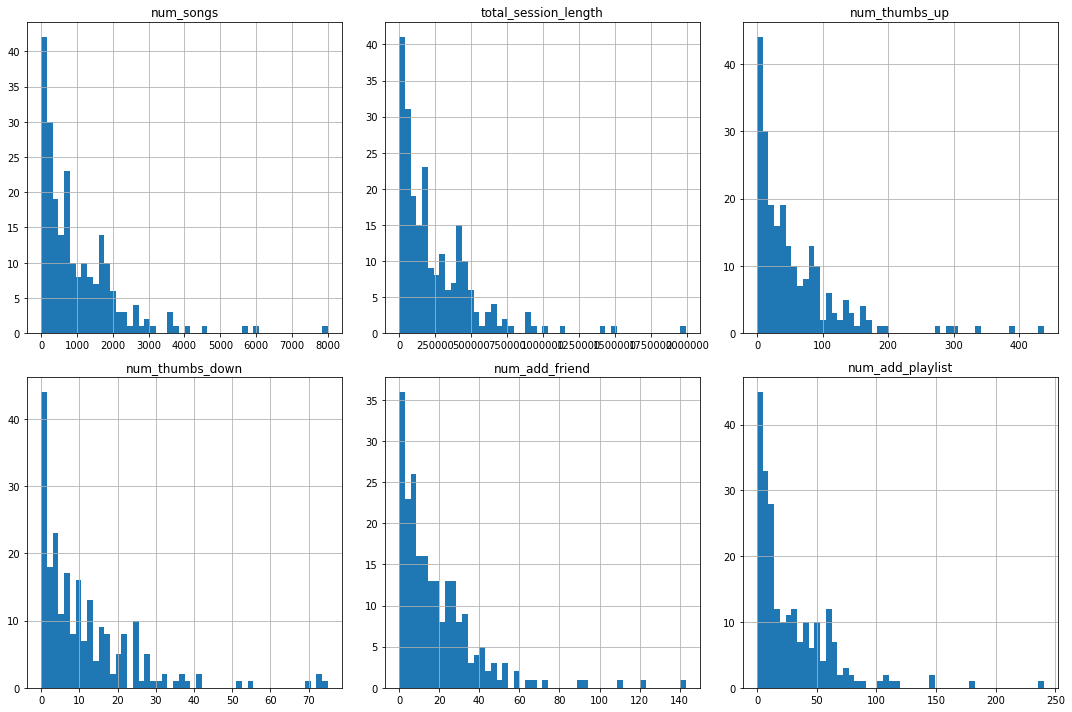

In [21]:
# Convert Spark DataFrame to Pandas for visualization
df_pd = features.toPandas()

# Print the column names to verify
print("Columns in DataFrame:", df_pd.columns)

# Check if the necessary columns are present
expected_columns = ['num_songs', 'total_session_length', 'num_thumbs_up', 'num_thumbs_down', 'num_add_friend', 'num_add_playlist']
missing_columns = [col for col in expected_columns if col not in df_pd.columns]
print("Missing columns:", missing_columns)

# Plot histograms of user interactions if all columns are present
if not missing_columns:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    df_pd.hist(column='num_songs', bins=50, ax=axes[0, 0])
    df_pd.hist(column='total_session_length', bins=50, ax=axes[0, 1])
    df_pd.hist(column='num_thumbs_up', bins=50, ax=axes[0, 2])
    df_pd.hist(column='num_thumbs_down', bins=50, ax=axes[1, 0])
    df_pd.hist(column='num_add_friend', bins=50, ax=axes[1, 1])
    df_pd.hist(column='num_add_playlist', bins=50, ax=axes[1, 2])
    plt.tight_layout()
    plt.show()
else:
    print("One or more necessary columns are missing:", missing_columns)


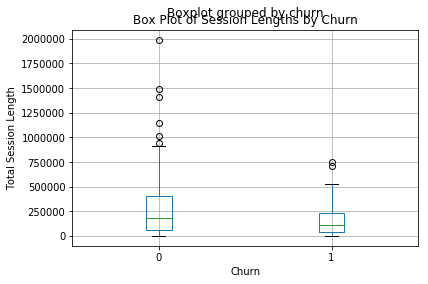

In [22]:
# Box plot of session lengths
plt.figure(figsize=(10, 6))
df_pd.boxplot(column='total_session_length', by='churn')
plt.title('Box Plot of Session Lengths by Churn')
plt.xlabel('Churn')
plt.ylabel('Total Session Length')
plt.show()


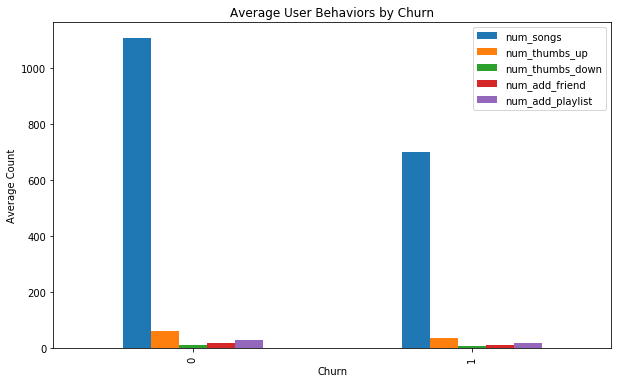

In [23]:
# Bar chart comparing churned vs. non-churned user behaviors
behaviors = ['num_songs', 'num_thumbs_up', 'num_thumbs_down', 'num_add_friend', 'num_add_playlist']
df_grouped = df_pd.groupby('churn')[behaviors].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.set_index('churn').plot(kind='bar', ax=ax)
plt.title('Average User Behaviors by Churn')
plt.xlabel('Churn')
plt.ylabel('Average Count')
plt.show()


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [19]:
# Split the data into training, validation, and testing sets
train, validation, test = features.randomSplit([0.6, 0.2, 0.2], seed=42)

train.cache()
validation.cache()
test.cache()


DataFrame[userId: string, num_songs: bigint, total_session_length: double, num_thumbs_up: bigint, num_thumbs_down: bigint, num_add_friend: bigint, num_add_playlist: bigint, churn: int]

In [20]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Define the feature columns
feature_columns = ["num_songs", "total_session_length", "num_thumbs_up", "num_thumbs_down", "num_add_friend", "num_add_playlist"]

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="unscaled_features")

# Scale features
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

# Create models
lr = LogisticRegression(labelCol="churn", featuresCol="features")
rf = RandomForestClassifier(labelCol="churn", featuresCol="features")
gbt = GBTClassifier(labelCol="churn", featuresCol="features")

# Create a function to train and evaluate models
def train_and_evaluate(model, train, validation):
    pipeline = Pipeline(stages=[assembler, scaler, model])
    model_fitted = pipeline.fit(train)
    predictions = model_fitted.transform(validation)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")
    f1_score = evaluator.evaluate(predictions)
    
    return model_fitted, f1_score

# Train and evaluate models
models = {"Logistic Regression": lr, "Random Forest": rf, "Gradient-Boosted Trees": gbt}
results = {}

for name, model in models.items():
    fitted_model, f1 = train_and_evaluate(model, train, validation)
    results[name] = {"model": fitted_model, "f1_score": f1}

# Display the results
for name, result in results.items():
    print(f"{name} F1 Score: {result['f1_score']}")


Logistic Regression F1 Score: 0.6388122204244788
Random Forest F1 Score: 0.6249084249084249
Gradient-Boosted Trees F1 Score: 0.5969471624266145


In [20]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Hyperparameter tuning for Logistic Regression (smaller grid)
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

crossval_lr = CrossValidator(estimator=Pipeline(stages=[assembler, scaler, lr]),
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=MulticlassClassificationEvaluator(labelCol="churn", metricName="f1"),
                             numFolds=3)

cvModel_lr = crossval_lr.fit(train)

# Evaluate the best Logistic Regression model on the validation set
validation_predictions_lr = cvModel_lr.transform(validation)
f1_score_lr = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1").evaluate(validation_predictions_lr)

print(f"Best Logistic Regression Model F1 Score on Validation Set: {f1_score_lr}")



Best Logistic Regression Model F1 Score on Validation Set: 0.5952380952380952


In [21]:
# Hyperparameter tuning for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=Pipeline(stages=[assembler, scaler, rf]),
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=MulticlassClassificationEvaluator(labelCol="churn", metricName="f1"),
                             numFolds=3)

cvModel_rf = crossval_rf.fit(train)

# Evaluate the best Random Forest model on the validation set
validation_predictions_rf = cvModel_rf.transform(validation)
f1_score_rf = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1").evaluate(validation_predictions_rf)

print(f"Best Random Forest Model F1 Score on Validation Set: {f1_score_rf}")


Best Random Forest Model F1 Score on Validation Set: 0.6388122204244788


In [22]:
# Evaluate the best Random Forest model on the test set
test_predictions_rf = cvModel_rf.transform(test)
test_f1_score_rf = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1").evaluate(test_predictions_rf)

print(f"Best Random Forest Model F1 Score on Test Set: {test_f1_score_rf}")

# Show some predictions
test_predictions_rf.select("userId", "churn", "prediction", "probability").show(5)


Best Random Forest Model F1 Score on Test Set: 0.706288032454361
+------+-----+----------+--------------------+
|userId|churn|prediction|         probability|
+------+-----+----------+--------------------+
|200002|    0|       1.0|[0.40493202439050...|
|    51|    1|       0.0|[0.91392054125247...|
|    15|    0|       0.0|[0.90812950115222...|
|     3|    1|       0.0|[0.92286438067207...|
|    34|    0|       0.0|[0.54225810350947...|
+------+-----+----------+--------------------+
only showing top 5 rows



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.